In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tricking your cerebellum with a reaching task
# Exercise 1 – Perturbation & after-effect

By: Robin Uhrich* and Ieva Kerseviciute*

*equal contribution

## Task 1: Implementation of perturbation

- Implement a sudden clockwise perturbation of 30°
- Implement a gradual counterclockwise perturbation of 3° (10 steps, 3 attempts each)

```{python}
    # TASK1: CALCULATE perturbed_mouse_pos
    # PRESS 'h' in game for a hint
    if perturbation_mode:
        if perturbation_type == "sudden":
            # sudden clockwise perturbation of perturbation_angle
            # 30 degree
            perturbed_mouse_angle = perturbation_angle

        elif perturbation_type == "gradual":
            # gradual counterclockwise perturbation of perturbation_angle in 10 steps, with perturbation_angle/10, each step lasts 3 attempts
            perturbed_mouse_angle = np.deg2rad(((gradual_attempts // 3) + 1) * np.rad2deg(perturbation_angle) / 10)
        
        rot_mat = np.array([[np.cos(perturbed_mouse_angle), -np.sin(perturbed_mouse_angle)],
                            [np.sin(perturbed_mouse_angle), np.cos(perturbed_mouse_angle)]])
        perturbed_mouse_pos = rot_mat @ (np.array(mouse_pos) - START_POSITION) + START_POSITION 
        circle_pos = perturbed_mouse_pos.tolist()
    else:
        circle_pos = pygame.mouse.get_pos()
```

## Task 2: Analysis of experiment on unbiased subjects

- Calculate the signed error_angles between target and circle cursor, exclude slow attempts where "MOVE FASTER" appeared.
- Plot the error angles over all attempts and highlight the experiment segments.
- What is the motor variability (MV) in the unperturbed segments?
- Run the experiment a second time with `mask_mode = false`. What do you observe in subject's movements in the now unmasked part?


In [2]:
experiment = pd.DataFrame({
    "Attempt": [1, 40, 80, 120, 160, 200, 240, 280, 320],
    "AttemptEnd": np.array([40, 80, 120, 160, 200, 240, 280, 320, 341]) - 1,
    "Perturbation": [
        "No perturbation", "Gradual",
        "No perturbation", "Sudden",
        "No perturbation", "Gradual reversed",
        "No perturbation", "Sudden reversed",
        "No perturbation"
    ]
})

n_attempts = 340

attempts = list(range(1, n_attempts + 1))

perturbations = []
for i in range(len(experiment)):
    start = experiment["Attempt"][i]
    end = experiment["Attempt"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    perturbations.extend([experiment["Perturbation"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Attempt": attempts, "Perturbation": perturbations })

In [3]:
def read_data(filename):
    res = np.load(filename, allow_pickle = True)
    return pd.DataFrame({
        "MoveFaster": res.item()["move_faster_logs"],
        "ErrorAngle": res.item()["error_angle_logs"],
        "Time": res.item()["time_logs"],
        "Attempt": np.arange(len(res.item()["move_faster_logs"])) + 1
    })


def preprocess(data, design):
    # Merge with experimental design describing perturbation conditions
    data = pd.merge(data, design)

    # Remove trials where move faster appeared
    data = data[data.MoveFaster == 0]
    data.reset_index(drop = True, inplace = True)

    return data


def evaluate_statistics(data):
    statistics = []

    for i, change in experiment.iterrows():
        selected_data = data[(data.Attempt >= change.Attempt) & (data.Attempt <= change.AttemptEnd)]
        statistics.append(pd.DataFrame({
            "Perturbation": change.Perturbation,
            "ErrorAngleStd": [selected_data.ErrorAngle.std()],
            "ErrorAngleMean": [selected_data.ErrorAngle.mean()],
            "TimeStd": [selected_data.Time.std()],
            "TimeMean": [selected_data.Time.mean()]
        }))

    statistics = pd.concat(statistics, ignore_index = True)

    return statistics

In [4]:
def plot_error_angle(subjects, experiment, stats):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

    color_map = mpl.colormaps["autumn"]
    n_colors = len(experiment.Perturbation.unique())
    colors = [color_map(idx / (n_colors - 1)) for idx in range(n_colors)]
    colors = dict(zip(experiment.Perturbation.unique(), colors))
    unique_periods = experiment.Perturbation.unique()

    # Show the different experimental periods
    for i, change in experiment.iterrows():
        label = change.Perturbation if change.Perturbation in unique_periods else ""
        unique_periods = unique_periods[unique_periods != change.Perturbation]

        start = change.Attempt
        end = change.AttemptEnd

        axs[0].axvspan(
            start, end,
            alpha = 0.2,
            label = label,
            color = colors.get(change.Perturbation)
        )

    for i, subject in enumerate(subjects):
        axs[0].plot(
            subject.Attempt,
            subject.ErrorAngle,
            linewidth = 1,
            label = f"Subject {i + 1}"
        )

    axs[0].set_ylabel("Error angle (degrees)")
    axs[0].set_xlabel("Attempt")
    axs[0].legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    axs[0].set_title("Error angle over attempts")

    # Plotting the statistics
    no_perturbation_stats = stats[stats.Perturbation == "No perturbation"]
    no_perturbation_stats.boxplot(ax = axs[1], column = "ErrorAngleStd", by = "Subject", showfliers = False)

    for subject, group in no_perturbation_stats.groupby("Subject"):
        x = ["Subject 1", "Subject 2", "Subject 3"].index(subject) + 1
        y = group["ErrorAngleStd"]
        axs[1].scatter([x] * len(y), y, color = "red", alpha = 0.7)

    axs[1].set_ylabel("Error angle (degrees)")
    axs[1].set_title("Motor variability")
    axs[1].set_xlabel("")

    # Remove the suptitle from boxplot
    plt.suptitle("")

    fig.tight_layout()

### Performing the experiment with _mask_mode = True_

In [5]:
subject1 = read_data("../logs_2025_01_15_15_08_41.npy")
subject1 = preprocess(subject1, full_experiment)

# TODO: remove below -- read actual subject data
import random

subject2 = subject1.copy()
subject2["ErrorAngle"] = subject2["ErrorAngle"] + [random.normalvariate(0, 0.5) for _ in range(len(subject1))]

subject3 = subject1.copy()
subject3["ErrorAngle"] = subject3["ErrorAngle"] + [random.normalvariate(0, 0.7) for _ in range(len(subject1))]
# TODO: remove above -- read actual subject data

# List of all subjects
subjects = [subject1, subject2, subject3]

# Evaluate subject statistics
stats = []
for i, subject in enumerate(subjects):
    subject_stats = evaluate_statistics(subject)
    subject_stats["Subject"] = f"Subject {i + 1}"
    stats.append(subject_stats)
stats = pd.concat(stats, ignore_index = True)

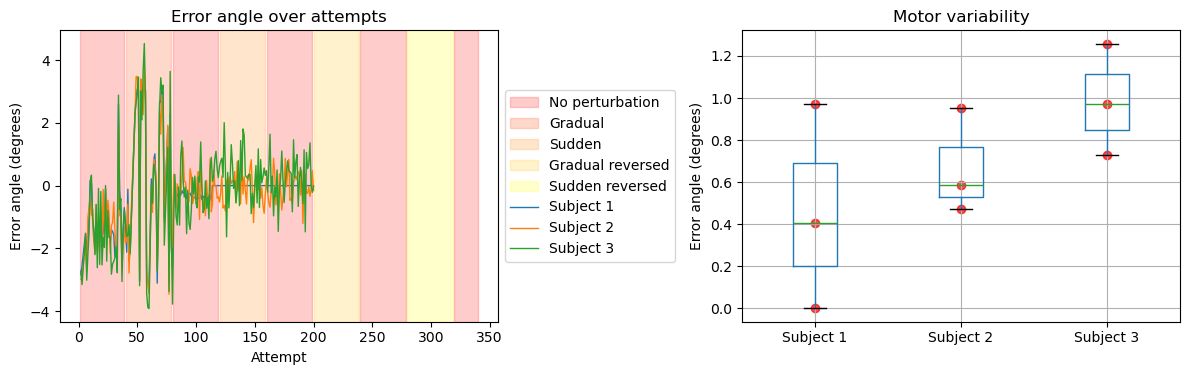

In [6]:
plot_error_angle(subjects, experiment, stats)

### Performing the experiment with _mask_mode = False_

In [7]:
subject1 = read_data("../logs_2025_01_15_15_08_41.npy")
subject1 = preprocess(subject1, full_experiment)

# TODO: remove below -- read actual subject data
import random

subject2 = subject1.copy()
subject2["ErrorAngle"] = subject2["ErrorAngle"] + [random.normalvariate(0, 0.5) for _ in range(len(subject1))]

subject3 = subject1.copy()
subject3["ErrorAngle"] = subject3["ErrorAngle"] + [random.normalvariate(0, 0.7) for _ in range(len(subject1))]
# TODO: remove above -- read actual subject data

# List of all subjects
subjects = [subject1, subject2, subject3]

# Evaluate subject statistics
stats = []
for i, subject in enumerate(subjects):
    subject_stats = evaluate_statistics(subject)
    subject_stats["Subject"] = f"Subject {i + 1}"
    stats.append(subject_stats)
stats = pd.concat(stats, ignore_index = True)

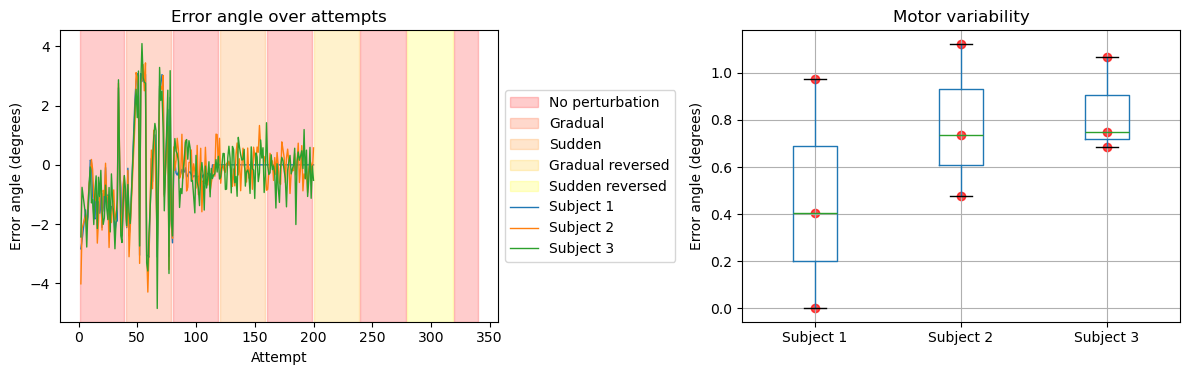

In [8]:
plot_error_angle(subjects, experiment, stats)

## Task 3: Discussion of your results
 
What do you see when perturbation is introduced? Is there an after-effect? What is the difference between gradual and sudden perturbation? Why is it important to mask the last part of the trajectory?

## Task 4: Implementation of our own idea